In [89]:
import torch
import config
import os
from binary_file_parser import unpack_drawing
import random
import numpy as np
import matplotlib.pyplot as plt

In [90]:
def sample_trajectories(n):
    '''Sample n trajectories from the Quick Draw dataset.'''
    # Get file handles for each word
    files = os.listdir(config.dataset_dir)
    file_handles = []
    for word in files:
        fname = os.path.join(config.dataset_dir, word)
        file_handles.append(open(fname, 'rb'))

    def adjust_trajectory(traj):
        '''Translates trajectory so that it starts at (0,0), then rotates so that the last point
        also has y-coordinate 0. Also scales to [0, 1]
        
        traj: (n, 2)
        '''
        # Translate trajectory to start at (0,0)
        traj -= traj[0]

        # Rotate trajectory to make the last point have y-coordinate 0
        angle = np.arctan2(traj[-1, 1], traj[-1, 0])
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                    [np.sin(angle), np.cos(angle)]])
        traj = traj @ rotation_matrix

        return traj / 255

    def is_trajectory_valid(traj):
        '''Checks that trajectory fits within certain bounding box and has minimum length
        
        traj: (n, 2)
        '''
        x_bounds = (-0.1, 0.3)
        y_bounds = (-0.1, 0.1)

        xs = traj[:, 0]
        ys = traj[:, 1]

        return x_bounds[0] <= xs.min() and xs.max() <= x_bounds[1] and\
               y_bounds[0] <= ys.min() and ys.max() <= y_bounds[1] and\
               len(traj) >= 4

    # Sample n trajectories
    res = []
    while True:
        # Pick random drawing from file handles, try again if it fails
        while True:
            random_file_handle = random.choice(file_handles)
            drawing = unpack_drawing(random_file_handle)
            if drawing is None: # No more drawings in category
                file_handles.remove(random_file_handle)
                continue
            if not drawing['recognized']: # Drawing was not recognized by AI (it was probably a bad drawing)
                continue
            break

        # Add trajectories from this drawing res
        for traj in drawing['image']:
            traj = np.array(list(zip(traj[0], traj[1])))
            traj = adjust_trajectory(traj)
            if is_trajectory_valid(traj):
                res.append(traj)
            if len(res) == n:
                break
        if len(res) == n:
            break

    # Close file handles
    for file_handle in file_handles:
        file_handle.close()
    
    return res

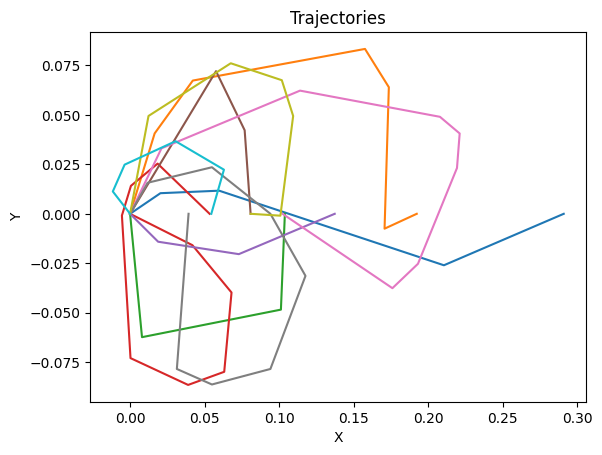

In [102]:
# plot trajectories on one graph
trajectories = sample_trajectories(10)

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot each trajectory on the same graph
for traj in trajectories:
    xs = traj[:, 0]
    ys = traj[:, 1]
    ax.plot(xs, ys)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Trajectories')

# Show the plot
plt.show()